In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
# Local Modules
import sys
import os.path
# sys.path.insert(0, os.path.abspath('/scratch/horta/coronawiki/'))
from helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from helpers.load import load_interventions, load_aggregated
from helpers.plot import plot_intervention, set_size
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

In [12]:
# Latex Configuration
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
fontpath = os.path.expanduser('~/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
#     'font.family': 'Linux Libertine Display',
    'text.usetex': True
}

mpl.rcParams.update(params)

In [13]:
agg = load_aggregated("../data/aggregated_timeseries.json.gz")
interventions = load_interventions("../data/interventions.csv")
df = pd.read_csv('../data/Global_Mobility_Report.csv.gz', compression="infer")


/Users/horta/opt/anaconda3/envs/youtube/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
import datetime
import numpy as np
baseline = (20200103, 20200206)
start_baseline = datetime.datetime.strptime(str(baseline[0]), "%Y%m%d")
end_baseline = datetime.datetime.strptime(str(baseline[1]), "%Y%m%d")

## Data Plot #1

In [15]:
italy = df[(df["country_region"] == "Italy") & (df["sub_region_1"].isna())]\
          .loc[:, ["date", "residential_percent_change_from_baseline"]].set_index("date")
italy.index = pd.to_datetime(italy.index)
inter =  agg["it"]["sum"].index.intersection(italy.index)
italy = italy.reindex(inter)
italy = italy["residential_percent_change_from_baseline"].head(45)
tmp_it = agg["it"]["sum"].reindex(inter).head(45)
mask_baseline = (agg["it"]["sum"].index <= end_baseline) & (agg["it"]["sum"].index >= start_baseline)
baseline = agg["it"]["sum"][mask_baseline]
baseline = pd.DataFrame(baseline, columns=["sum"]).reset_index()
baseline["dow"] = baseline["index"].apply(lambda x: x.weekday())
dow_baseline = dict(baseline.groupby("dow")["sum"].median())
baseline = np.array([dow_baseline[dow] for dow in tmp_it.index.weekday])
tmp_it = (tmp_it-baseline)/baseline *100


In [16]:
sweden = df[(df["country_region"] == "Sweden") & (df["sub_region_1"].isna())]\
          .loc[:, ["date", "residential_percent_change_from_baseline"]].set_index("date")
sweden.index = pd.to_datetime(sweden.index)
inter =  agg["sv"]["sum"].index.intersection(sweden.index)
sweden = sweden.reindex(inter)
sweden = sweden["residential_percent_change_from_baseline"].head(45)
tmp_sv = agg["sv"]["sum"].reindex(inter).head(45)
mask_baseline = (agg["sv"]["sum"].index <= end_baseline) & (agg["it"]["sum"].index >= start_baseline)
baseline = agg["sv"]["sum"][mask_baseline]
baseline = pd.DataFrame(baseline, columns=["sum"]).reset_index()
baseline["dow"] = baseline["index"].apply(lambda x: x.weekday())
dow_baseline = dict(baseline.groupby("dow")["sum"].median())
baseline = np.array([dow_baseline[dow] for dow in tmp_it.index.weekday])
tmp_sv = (tmp_sv-baseline)/baseline *100


## Data Plot #2

In [17]:
correspond = [
    ("it", "Italy"),
    ("sv", "Sweden"),
    ("no", "Norway"),
    ("da", "Denmark"),
    ("fr", "France"),
    ("de", "Germany"),
    ("nl", "Netherlands"),
    ("sr", "Serbia"),
    ("fr", "France"),
    ("ko", "South Korea"),
    ("ja", "Japan"),
    ("fi", "Finland")
]

import datetime
import numpy as np
baseline = (20200103, 20200206)
start_baseline = datetime.datetime.strptime(str(baseline[0]), "%Y%m%d")
end_baseline = datetime.datetime.strptime(str(baseline[1]), "%Y%m%d")

dfs = []

for agg_code, country_code in correspond:
    tmp = df[(df["country_region"] == country_code) & (df["sub_region_1"].isna()) &
            (df["metro_area"].isna())]\
          .loc[:, ["date", "residential_percent_change_from_baseline"]].set_index("date")
    
    tmp.index = pd.to_datetime(tmp.index)
    inter =  agg[agg_code]["sum"].index.intersection(tmp.index)
    
    tmp = tmp.reindex(inter)
    tmp = tmp["residential_percent_change_from_baseline"]

    tmp_agg = agg[agg_code]["sum"].reindex(inter) + agg[agg_code + ".m"]["sum"].reindex(inter)
    mask_baseline = (agg[agg_code]["sum"].index <= end_baseline) &\
                    (agg[agg_code]["sum"].index >= start_baseline)
    baseline = agg[agg_code]["sum"][mask_baseline] + agg[agg_code + ".m"]["sum"][mask_baseline] 
    baseline = pd.DataFrame(baseline, columns=["sum"]).reset_index()
    baseline["dow"] = baseline["index"].apply(lambda x: x.weekday())
    dow_baseline = dict(baseline.groupby("dow")["sum"].median())
    baseline = np.array([dow_baseline[dow] for dow in tmp.index.weekday])
    tmp_agg = (tmp_agg-baseline)/baseline * 100
    
    
    mobility = interventions[agg_code]["Mobility"]
    pre = [mobility - relativedelta(days=28), mobility]
    pos = [mobility, mobility + relativedelta(days=28)]

    mask_pre = (tmp.index >= pre[0]) & (tmp.index < pre[1])
    mask_pos = (tmp_agg.index >= pos[0]) & (tmp_agg.index < pos[1])

    dfs.append({
        "lang": agg_code,
        "mobility_pre": tmp[mask_pre].mean(),
        "mobility_pos": tmp[mask_pos].mean(),
        "pageview_pre": tmp_agg[mask_pre].mean(),
        "pageview_pos": tmp_agg[mask_pos].mean()
    })
        

df_results = pd.DataFrame(dfs)

## Image

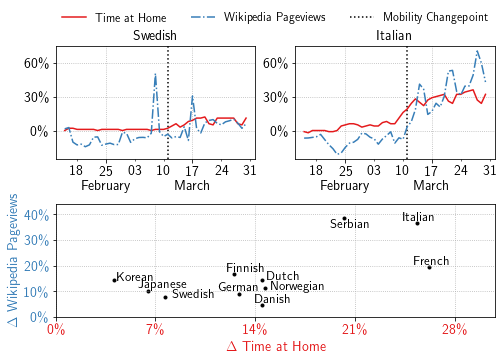

In [18]:
fig = plt.figure(constrained_layout=False, figsize=(7,5))
gs = fig.add_gridspec(2, 2, hspace=0.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax =  ax2
ax.plot(italy.index , italy.values, color="#e41a1c", zorder=9)
ax.plot(tmp_it.index, tmp_it.values, color="#377eb8", ls="-.", zorder=10)
ax.set_title("Italian")

ax = ax1
ax.plot(sweden.index , sweden.values, color="#e41a1c", zorder=9)
ax.plot(tmp_sv.index, tmp_sv.values, color="#377eb8", ls="-.", zorder=10)
ax.set_title("Swedish")

months_fmt = mdates.DateFormatter('%d\n%B')
day_fmt = mdates.DateFormatter('%d')
for ax in [ax1, ax2] :
    ax.xaxis.set_major_formatter(months_fmt)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=3))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_minor_formatter(day_fmt)

    ax.set_ylim([-25, 75])
    ax.set_yticks([0, 30, 60])
    ax.set_yticklabels(['0\%', '30\%', '60\%'])
    ax.grid(ls=":")

set_size(fig, (7, 6))

ax = ax3
idx = 0

adjust = {
    "sr": (-1, -3.5),
    "ko": (0.2, 0),
    "fi": (-0.5, 1),
    "it": (-1, 1.2),
    "de": (-1.5, 1.5),
    "fr": (-1, 1),
    "da": (-0.5, 1),
    "nl": (0.3, 0),
    "sv": (0.5, 0),
    "no": (0.4, -0.8),
    "ja": (-0.7, 1.2),
}

for code in codes:
    if code == "en":
        continue
    df_ = df_results[df_results.lang == code]
    vals = df_.values[0]
    
    ax.scatter([(vals[2] - vals[1])], 
               [(vals[4] - vals[3])], 
               alpha=1, marker=".", color="black")
    ax.text((vals[2] - vals[1]) + adjust[code][0], 
            (vals[4] - vals[3]) + adjust[code][1],
            helper_langs[vals[0]], size=13, transform=ax.transData)

ax.set_yticks([0, 10, 20, 30, 40])
ax.set_yticklabels(["0\%", "10\%", "20\%", "30\%", "40\%"], color="#377eb8")
ax.set_ylim([0, 44])


ax.set_xticks([0, 7, 14, 21, 28])
ax.set_xticklabels(["0\%", "7\%", "14\%", "21\%", "28\%"], color="#e41a1c")
ax.set_xlim([0, 30.8])
ax.grid(ls=":")

ax.set_xlabel("$\Delta$ Time at Home", color="#e41a1c")
ax.set_ylabel("$\Delta$ Wikipedia Pageviews", color="#377eb8")


lines = [
    Line2D([0], [0], color="#e41a1c", lw=1.5, ls="-"),
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-."),
    Line2D([0], [0], color="#000000", lw=1.5, ls=":")

]

ax3.legend(
    handles=lines,
    labels=["Time at Home", "Wikipedia Pageviews", "Mobility Changepoint"],
    loc='upper center', bbox_to_anchor=(0.5, 2.8),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)


ax1.axvline(interventions["sv"]["Mobility"], ls=":", color="black", zorder=1)
ax2.axvline(interventions["it"]["Mobility"], ls=":", color="black", zorder=1)


set_size(fig, (7, 5))
fig.savefig("../images/teaser.pdf", bbox_inches="tight")

---